# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
#from C51 import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotionTest2 import * 
from MCSAmericanOptionPricing import *
import math

seed = 24 #1 #time.time()
random.seed(seed)
print('Seed is:' + str(seed))

/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/misc/home/re

Seed is:24


### Variable settings

In [2]:
"""So = 100 #spot_price #110 #90 #100 110 #127.62 #90
strike_price = 100 #130 #100
mu = 10/100 #risk_free_rate #0.001 #5/100
sigma = 0.20 #volatility # the historical vols or implied vols
dividend_rate = 0.0 #0.0163 #dividend yield of 1.63%
num_seeds = 20000"""
risk_free_rate = 5/100
mu = risk_free_rate
sigma = 0.20
num_seeds = 200 #60

In [3]:
save_model_freq = 10000 #5000
Normalization = False
Window_Normalization = False #True #False
test_data_ratio = 0.2 #0.3 # 0.2

architecture = 0 #3 #0 #1 #2 #3 #4 #5
nbFilters = 32 #16 #1
paddingType = 'same' #'causal' # 'valid'
huber_loss = True #False
dueling_type = 'max' #'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = True
batch_size = 64 #16 #32 #128 #60 #20 #4 #How many experience traces to use for each training step.
memory_capacity = 3000 #3000 #1000
learning_rate = 0.0025 #0.00025 #0.01 0.025 0.0025 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd() #"C:\Code_RL\2019_11_21_shuffled_GBM_version" #"C:\\Code_RL" # os.getcwd()

history_t = 15 #5 #15 #2 #15 ##
option_T = 50 #65 #50 #100 #365 #100 #200 #365 #65 #30 #15 #40 #30 ##
#build_warm_up_state_t = option_T // 3 #option_T // 2
input_size = history_t + 2
is_training = True

In [4]:
"""stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r') """

"stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',\n              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',\n              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',\n              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',\n              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',\n               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',\n               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',\n               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',\n              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',\n               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',\n               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',\n              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',\n               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',\n              

min value of data: 120.17629833877204, max value of data: 160.13925789827366
train_size: 743
test_size: 185
min value of data: 45.986248424777116, max value of data: 73.5797532231566
train_size: 743
test_size: 185
min value of data: 65.78933875750742, max value of data: 111.7371006220455
train_size: 743
test_size: 185
min value of data: 82.62843738885131, max value of data: 130.93914909050758
train_size: 743
test_size: 185
min value of data: 95.78714203983104, max value of data: 145.15409748626826
train_size: 743
test_size: 185
min value of data: 53.235928082108906, max value of data: 90.07962858852832
train_size: 743
test_size: 185
min value of data: 115.53356854023272, max value of data: 216.24842905183326
train_size: 743
test_size: 185
min value of data: 35.05825848444514, max value of data: 83.16582914572865
train_size: 743
test_size: 185
min value of data: 128.14003706420576, max value of data: 296.3874826904585
train_size: 743
test_size: 185
min value of data: 61.04042515811036, 

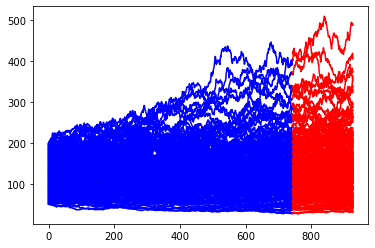

In [5]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    #train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 2118
num_episodes_per_epoch: 135600
min value of stock: 106.01567271416633, max value of stock: 197.0211505221744


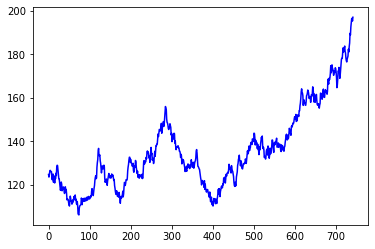

In [6]:
############################################################################
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [7]:
num_actions = 2
num_atoms=51
vmax=float(10.)
vmin=float(-1.)
delta_z = (vmax - vmin) / float(num_atoms - 1)
_support = [vmin + i * delta_z for i in range(num_atoms)]

### Implementing the network itself

In [8]:
class Qnetwork():
    def __init__(self,myScope):
        
        self._support = tf.linspace(vmin, vmax, num_atoms)
        
        self.scalarInput = tf.placeholder(shape=[None,input_size],dtype=tf.float32)
        
        # depending on the chosen architecture, data is processed through differents layers
        
        # convolutions are used in all type, except architecture 0 which only uses LSTM
        if architecture != 0:
          self.InputConvIn = tf.reshape(self.scalarInput,shape=[-1,input_size,1], name='InputConvIn')
          self.conv1 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.InputConvIn)
        
        if architecture == 0: # LSTM only
          self.scalarInputFlattened = tf.keras.layers.Flatten()(self.scalarInput)
        elif architecture == 1: # only one convolution
          self.conv1flattened = tf.reshape(self.conv1,shape=[-1,self.conv1.shape[1]*self.conv1.shape[2]], name='conv1flattened')
        elif architecture == 2: # only one convolution followed by max pooling
          self.maxPooling1D = tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.maxPooling1Dflattened = tf.reshape(self.maxPooling1D,shape=[-1,self.maxPooling1D.shape[1]*self.maxPooling1D.shape[2]], name='maxPooling1Dflattened')
        elif architecture == 3: # only one convolution followed by average pooling
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.AveragePooling1Dflattened = tf.reshape(self.AveragePooling1D,shape=[-1,self.AveragePooling1D.shape[1]*self.AveragePooling1D.shape[2]], name='AveragePooling1Dflattened')  
        elif architecture == 4: #VGG (one block of 2 convolutions followed by avg pooling)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.conv1)
          self.AveragePooling1D4 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened4 = tf.reshape(self.AveragePooling1D4,shape=[-1,self.AveragePooling1D4.shape[1]*self.AveragePooling1D4.shape[2]], name='AveragePooling1Dflattened4')
        elif architecture == 5: #Lenet (conv, avg pooling, conv, avg pooling)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,#5, #3, #maybe unstable calculations because of 5 instead of 3
                                               strides=1,
                                               padding= paddingType, #'same',
                                               #activation=tf.keras.activations.hard_sigmoid
                                               #activation=tf.keras.activations.sigmoid
                                               #activation=tf.keras.activations.tanh
                                               activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.AveragePooling1D5 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened5 = tf.reshape(self.AveragePooling1D5,shape=[-1,self.AveragePooling1D5.shape[1]*self.AveragePooling1D5.shape[2]], name='AveragePooling1Dflattened5')
        elif architecture == 6: #Googlenet (Inception net: combine (conv&avgPooling) + conv1 + conv3 + conv5)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv11 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=1,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv3 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=3,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv5 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=5,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.filterconcatenation = tf.concat([self.conv11, self.conv3, self.conv5, self.AveragePooling1D], 2, name = 'filterconcatenation')
          self.filterconcatenationflattened = tf.reshape(self.filterconcatenation,shape=[-1,self.filterconcatenation.shape[1]*self.filterconcatenation.shape[2]], name='filterconcatenationflattened')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
 
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        if architecture == 0:
          self.convFlat = tf.reshape(self.scalarInputFlattened,[self.batch_size,self.trainLength,input_size])
        elif architecture == 1:
          self.convFlat = tf.reshape(self.conv1flattened,[self.batch_size,self.trainLength,self.conv1flattened.shape[1]])
        elif architecture == 2:
          self.convFlat = tf.reshape(self.maxPooling1Dflattened,[self.batch_size,self.trainLength,self.maxPooling1Dflattened.shape[1]])
        elif architecture == 3:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened.shape[1]])
        elif architecture == 4:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened4,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened4.shape[1]])
        elif architecture == 5:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened5,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened5.shape[1]])
        elif architecture == 6:
          self.convFlat = tf.reshape(self.filterconcatenationflattened,[self.batch_size,self.trainLength,self.filterconcatenationflattened.shape[1]])
        
        # use cudnn-based cells to leverage Nvidia GPUs
        single_cell = lambda: tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(h_size)
    
        # NOTE: Even if there's only one layer, the cell needs to be wrapped in MultiRNNCell.
        lstm_cells = [single_cell() for _ in range(num_layers)]
        if is_training and apply_dropout and dropout < 1:
            lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
            ) for lstm in lstm_cells]
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

        self.state_in = tf.placeholder(tf.float32, [num_layers, 2, None, h_size])
        state_per_layer_list = tf.unstack(self.state_in, axis=0)
        rnn_tuple_state = tuple(
            [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )
        
        # calculate the real length of each episode (since remaining states are filled with 0s after selling)
        # This is required by RNN 
        self.seq_len = length(self.convFlat)
        
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                cell=multi_cell,
                inputs=self.convFlat,                                    
                dtype=tf.float32,
                initial_state=rnn_tuple_state, 
                sequence_length=self.seq_len,
                scope=myScope+'_lstm')
        

        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        
        self.weights_initializer = tf.contrib.slim.variance_scaling_initializer(factor=1.0 / np.sqrt(3.0), mode='FAN_IN', uniform=True)
        self.net = tf.contrib.slim.fully_connected(
              self.rnn, #self.net,
              num_actions * num_atoms,
              activation_fn=None,
              weights_initializer=self.weights_initializer)

        self.logits = tf.reshape(self.net, [-1, num_actions, num_atoms])
        self.probabilities = tf.contrib.layers.softmax(self.logits)
        self.q_values = tf.reduce_sum(self._support * self.probabilities, axis=2)
        
        self.predict = tf.argmax(self.q_values,1)
        
            
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)    
        # create placeholder for target_distribution
        self.target_distribution = tf.placeholder(shape=[None,num_atoms],dtype=tf.float32)

        # size of indices: batch_size x 1.
        self.indices = tf.range(tf.shape(self.logits)[0])[:, None]
        # size of reshaped_actions: batch_size x 2.
        self.reshaped_actions = tf.concat([self.indices, self.actions[:, None]], 1)
        # For each element of the batch, fetch the logits for its selected action.
        self.chosen_action_logits = tf.gather_nd(self.logits,
                                            self.reshaped_actions)

        self.td_error = tf.nn.softmax_cross_entropy_with_logits(labels=self.target_distribution,logits=self.chosen_action_logits)
        # In order to only propogate accurate gradients through the network, we can mask the first
        # half of the losses for each trace as per Lample & Chaplot 2016
        # We can also use gradual weights to avoid neglecting short episodes at the beginning
        # maybe seq_len used in averaging should also change subsequently !
        if mask_type == 'maskFirstHalf':
            self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
            self.maskB = tf.ones([self.batch_size,self.trainLength//2])
            self.mask = tf.concat([self.maskA,self.maskB],1)
            self.mask = tf.reshape(self.mask,[-1])
            self.td_error = self.td_error * self.mask
        elif mask_type == 'maskByWeights': 
            #self.mask_weights = tf.range(start=0, limit=1, delta=1/self.trainLength)
            self.mask_weights = tf.range(start=0.1, limit=1, delta=0.9/tf.cast(self.trainLength, tf.float32))
            self.mask = tf.tile(self.mask_weights, [self.batch_size])
            self.td_error = tf.multiply(self.td_error, tf.cast(self.mask, tf.float32))
        elif mask_type == 'default':
            self.td_error = self.td_error
        
        # divide by the real length of episodes instead of averaging which is incorrect
        self.loss = tf.cast(tf.reduce_sum(self.td_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)
        self.check_ops = tf.debugging.check_numerics( self.loss, "self.loss contain Nan or Inf", name="self.check_ops")
        
        if optimizer_type == 'Adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        elif optimizer_type == 'GradientDescent':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif optimizer_type == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        if apply_grad_clipping:
            # calculate gradients and clip them to handle outliers
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clipping)
            self.updateModel = optimizer.apply_gradients(
                    zip(grads, tvars),
                    # global_step=tf.contrib.framework.get_or_create_global_step(),
                    name="updateModel")
        else:
            self.updateModel = optimizer.minimize(self.loss, name="updateModel")

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [9]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [10]:
#Setting the training parameters
num_layers = 3 # Number of layer of LSTM
h_size = 512 #256 #512 #128 #512 #256 #512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #30 #10 #5 #How often to perform a training step.
update_online_freq = 5 #10 #5 #3 #5
update_target_freq = 30 #300 #30
#gamma = discount_factor #.99 #.95 #1 #Discount factor on the target Q-values
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #0.1 #1 #Starting chance of random action
endE = 0.1 #0.01 #0.1 #Final chance of random action
num_epochs = 5
num_episodes = env.get_total_num_episodes_per_epoch()*num_epochs #30 #50000 #20000 #100000 #20000 #3000 #20000 #30000 #10000 #4000 #100000 #40000
pre_train_episodes = int(memory_capacity * 0.1) # 0.25 300 #300 #200 #600 #200
annealing_episodes = int(num_episodes * 0.3) #4*memory_capacity #0.7*memory_capacity #400 #memory_capacity #400
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01 #0.008 #0.02
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T #env.get_max_episode_time() #option_T + build_warm_up_state_t
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
summaryEpoch = env.get_total_num_episodes_per_epoch()
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = False # use soft or hard updates
#trained_model_name = os.path.join(path, 'architecture' + str(architecture) + '-option_T' + str(option_T) + '-history_t' + str(history_t) + '-num_episodes' + str(num_episodes) + '-tau' + str(tau) + '-softUpdate' + str(softUpdate) + '-dropout' + str(dropout) + '-mask' + str(mask_type) + '-dueling_type' + str(dueling_type) + '-So' + str(So) + '-strike_price' + str(strike_price) + '-mu' + str(mu) + '-sigma' + str(sigma) + '-num_seeds' + str(num_seeds))
trained_model_name = os.path.join(path, 'C51_noSoft_arch' + str(architecture)\
                    + '-option_T' + str(option_T) + '-history_t' + str(history_t)\
                    + '-num_episodes' + str(num_episodes)\
                    + '-softUpdate' + str(softUpdate) + '-tau' + str(tau)\
                    + '-dropout' + str(dropout) + str(apply_dropout)\
                    + '-num_layers' + str(num_layers) #+ '-apply_dropout' + str(apply_dropout)\
                    + '-freq' + str(update_target_freq) + '-batch' + str(batch_size)\
                    + '-capacity' + str(memory_capacity) + '-lambda' + str(learning_rate))
#final_trained_model_name = trained_model_name + '-final'
final_trained_model_name = 'C51_noSoft_arch0-option_T50-history_t15-num_episodes203400-softUpdateFalse-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-final'
final_trained_model_name = os.path.join(path, final_trained_model_name)
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
#print('#discount_factor: ' + str(discount_factor))
print('#gamma: ' + str(gamma))

#num_episodes: 678000
#trace_length: 38
#gamma: 0.9998016069840849


In [11]:
e=0

### Testing the network on train set again

In [12]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 2118
num_episodes_per_epoch: 135600
min value of stock: 106.01567271416633, max value of stock: 197.0211505221744


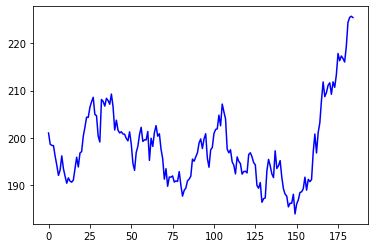

In [13]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [14]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/C51_noSoft_arch0-option_T50-history_t15-num_episodes203400-softUpdateFalse-tau0.001-dropout0.1999

In [15]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

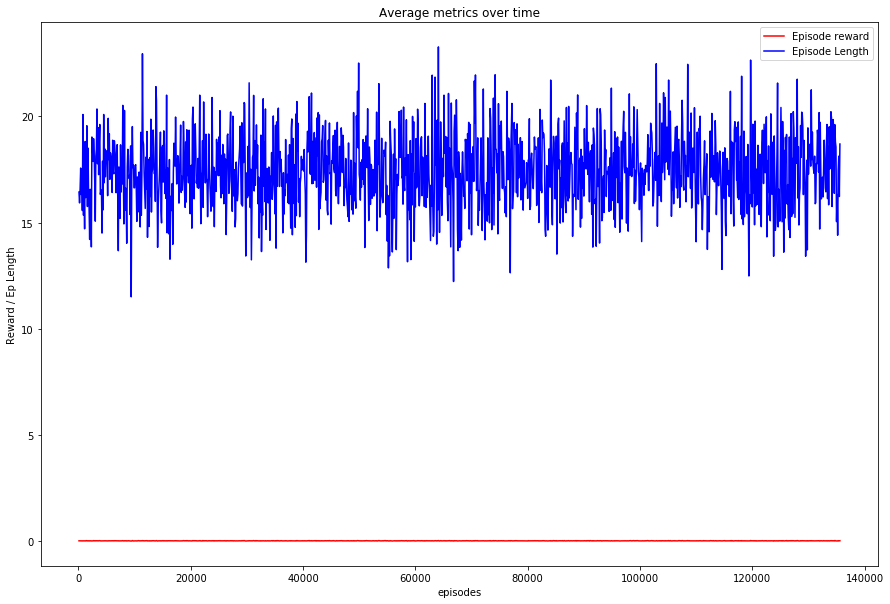

In [16]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

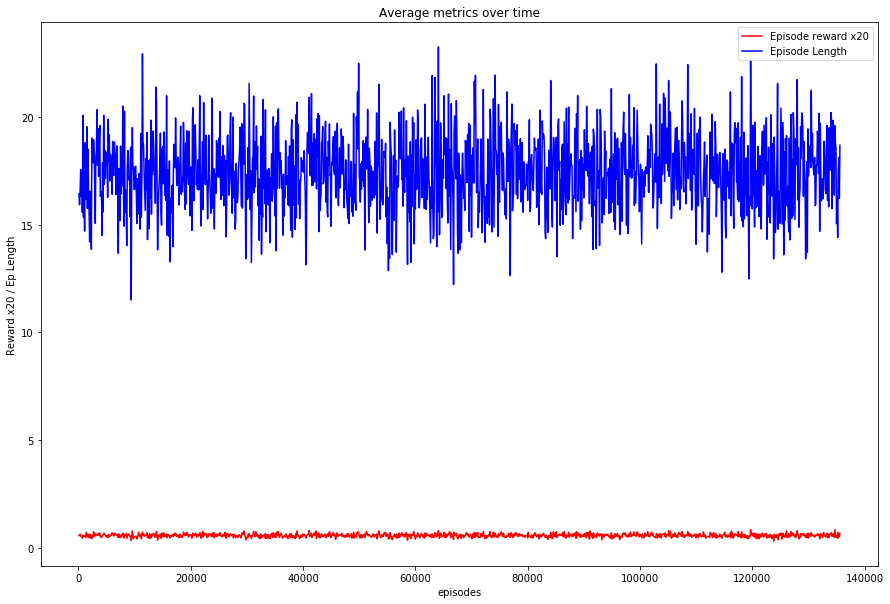

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

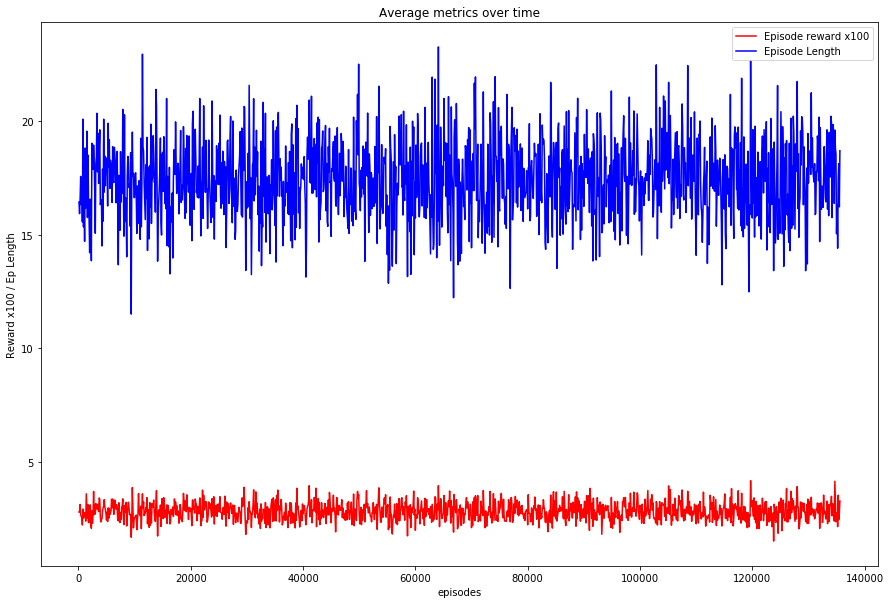

In [18]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

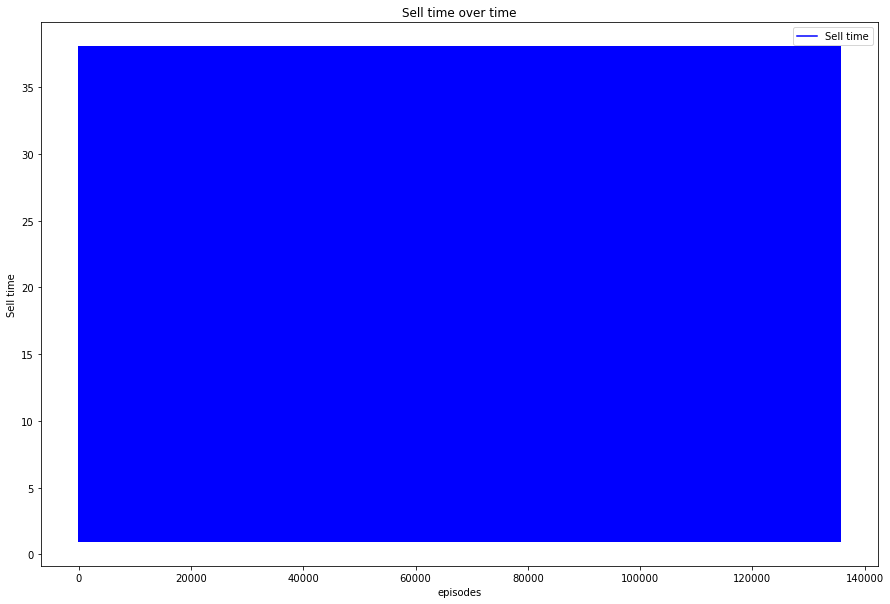

In [19]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Testing the network

In [20]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 375
num_episodes_per_epoch: 24000
min value of stock: 183.89506559405115, max value of stock: 225.71786417155334


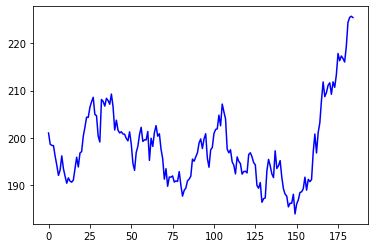

In [21]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [22]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/C51_noSoft_arch0-option_T50-history_t15-num_episodes203400-softUpdateFalse-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.02329685698849977	14.28
episode 200: 	0.0270847905273154	17.0
episode 300: 	0.029208827918286148	16.09
episode 400: 	0.028280412951005137	17.85
episode 500: 	0.02966420190377034	18.72
episode 600: 	0.028222235154597694	18.33
episode 700: 	0.03409839452708014	19.65
episode 800: 	0.02246465492522552	15.78
episode 900: 	0.030345032553668178	18.8
episode 1000: 	0.027944399493614415	18.22
episode 1100: 	0.024829770164162688	15.61
episode 1200: 	0.02880569822485052	17.05
episode 1300: 	0.02343567769867971	15.16
episode 1400: 	0.021742142548380666	14.57
episode 1500: 	0.03229380834137305	17.85
episode 1600: 	0.028227085454000288	

In [23]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

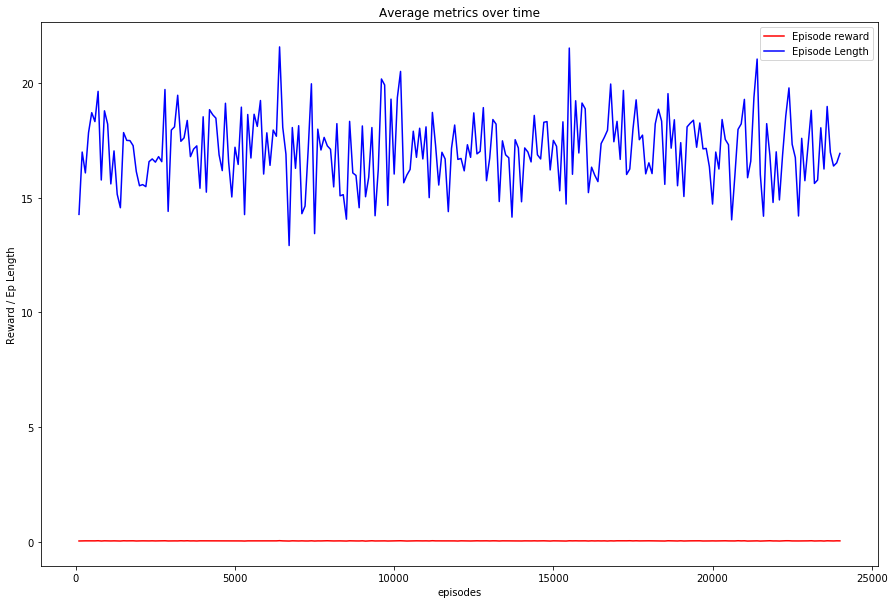

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

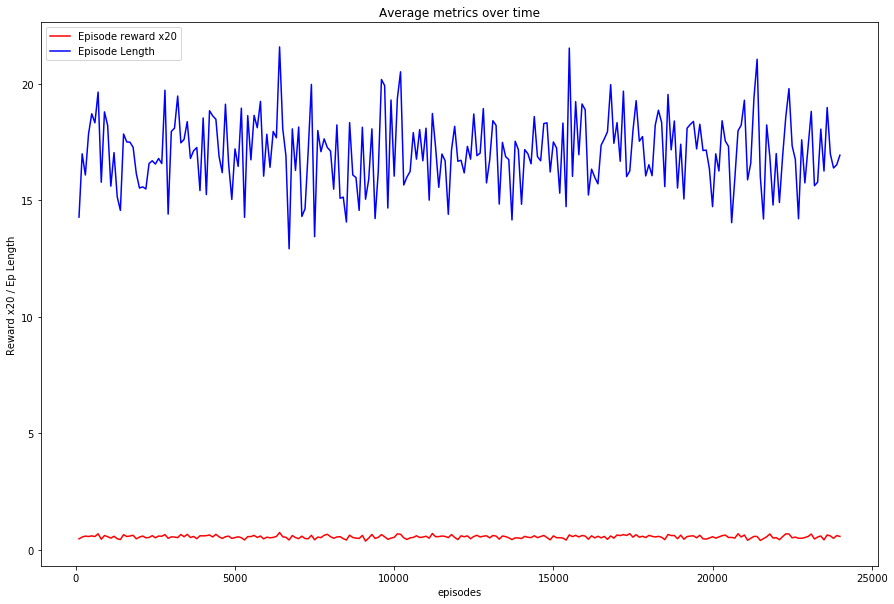

In [25]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

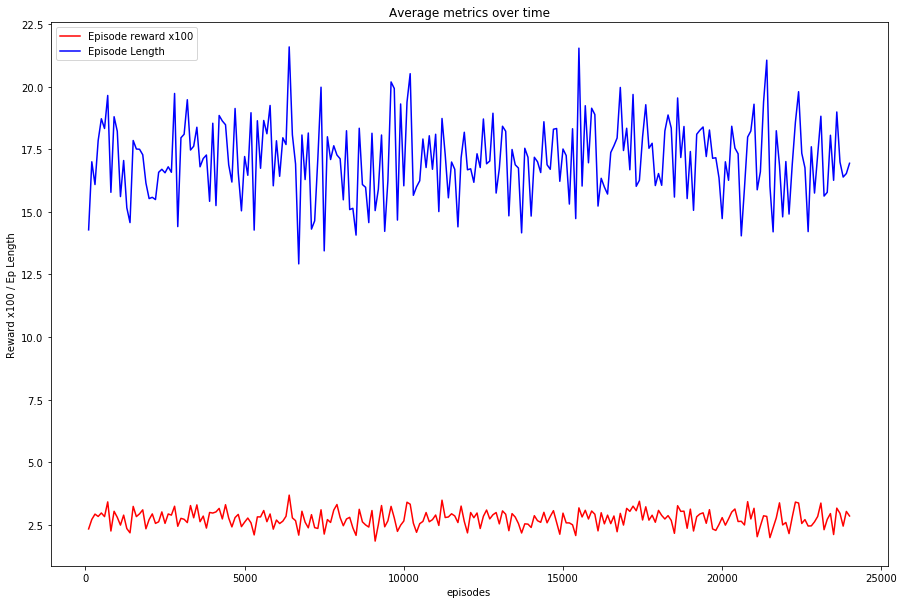

In [26]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

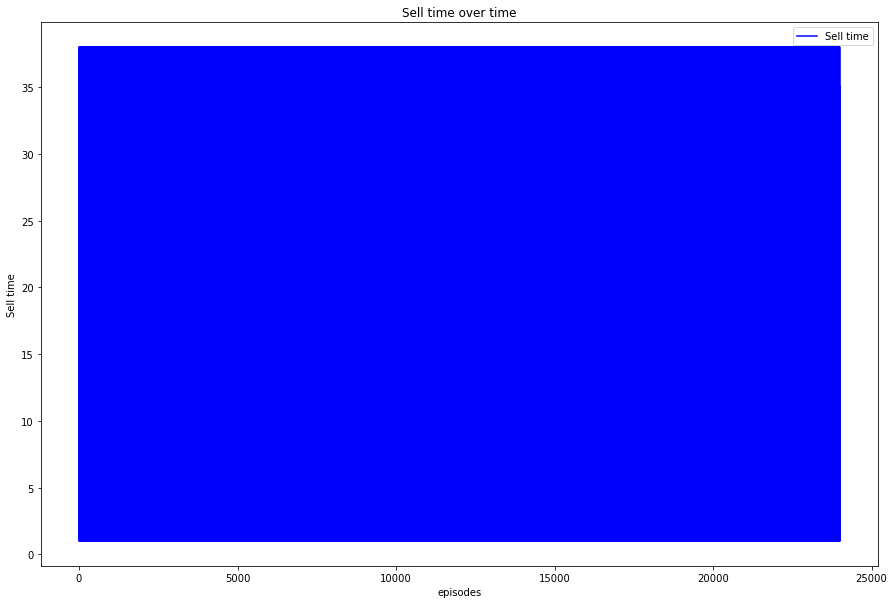

In [27]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Max price over history [Benchmark]

In [28]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
# Have a look at the RL notebook for more correct tests (slightly changed)
begin_time = time.time()

test = 'MaxValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:1'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.026221007580406987	16.17	0
episode 200: 	0.02761500867984468	18.39	0
episode 300: 	0.03004228328108191	17.28	0
episode 400: 	0.029231731722639456	19.13	0
episode 500: 	0.02538201177538868	20.61	0
episode 600: 	0.029486302945907976	19.5	0
episode 700: 	0.0341037250792363	21.35	0
episode 800: 	0.023413715875285703	16.91	0
episode 900: 	0.02977045687538082	20.24	0
episode 1000: 	0.025605071647911686	19.13	0
episode 1100: 	0.024942763907450618	16.91	0
episode 1200: 	0.028211546301342715	18.39	0
episode 1300: 	0.023751203999850392	16.91	0
episode 1400: 	0.021494323838889252	15.06	0
episode 1500: 	0.028721248602870147	19.5	0
episode 1600: 	0.02820122293318343	18.76	0
episode 1700: 	0.029229799863788535	18.76	0
episode 1800: 	0.028237029000265704	19.13	0
episode 1900: 	0.023121546293210112	17.65	0
episode 2000: 	0.026901016491695316	16.91	0
episode 2100: 	0.027901108556103137	18.39	0
episode 2200: 	0.02637037629457613	16.91	0
episode 2300: 	0.026596022956649125	17.28	0
episode

In [29]:
# 4000 episodes
# Select state of Max price over history [Benchmark]
#Average reward per episode: 0.0005877807673596729%
#Time to execute: 0.09947771628697713min

# 10000 episodes of training
#Average reward per episode: 0.0004938414456624297%
#Time to execute: 0.5947879354159037min

# 23000 episodes of training
#Average reward per episode: 0.0005705326210584273%
#Time to execute: 0.8882605234781901min

# 23000 episodes
#Average reward per episode: 0.0010192164676906157%
#Time to execute: 0.5056182742118835min

# 23000 episodes
#Total average reward per episode: 0.0009947041707927247
#Time to execute: 0.6030449350674947min

# 23000 episodes
#Total average reward per episode: 0.0009401450698119521
#Time to execute: 0.9448242465655009min

# 23000 episodes
#Total average reward per episode: 0.0003986495802468716
#Time to execute: 0.5700281739234925min

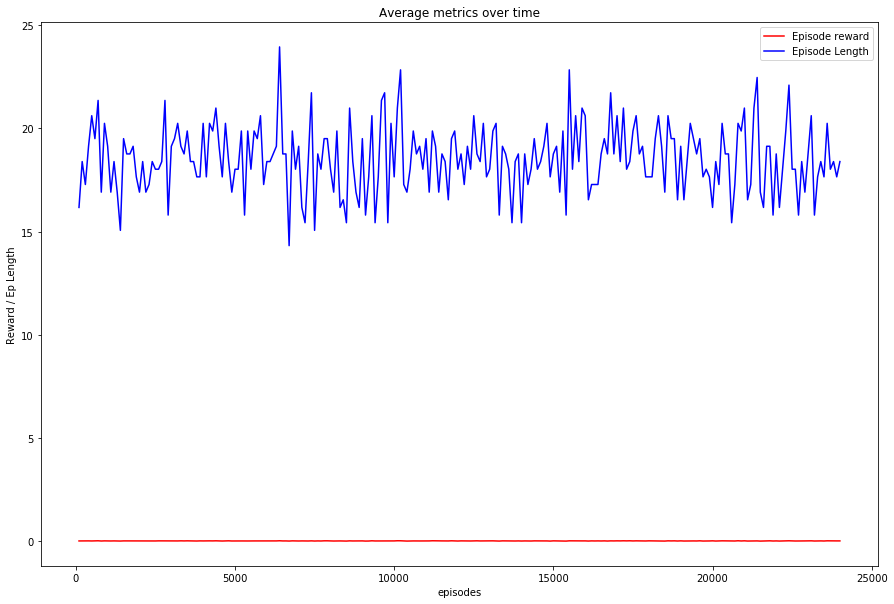

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

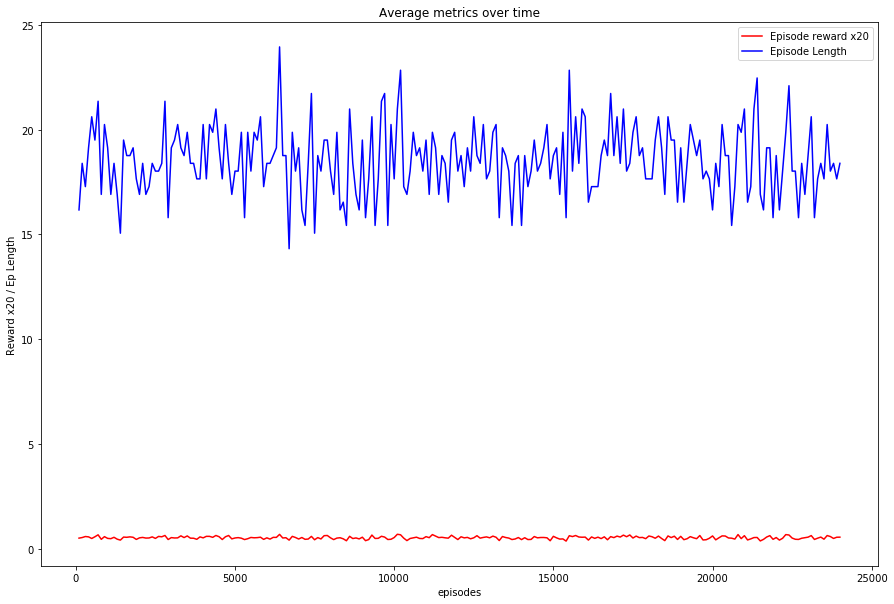

In [31]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

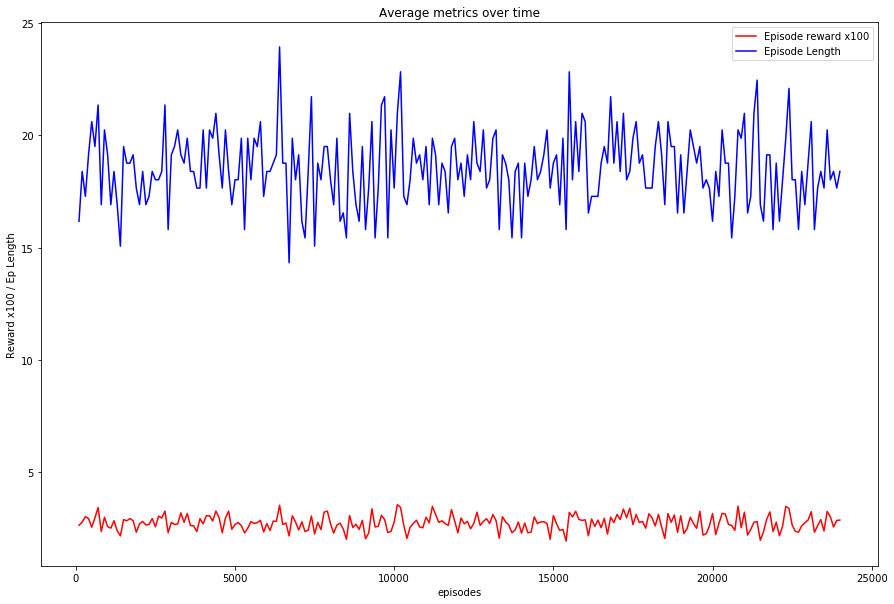

In [32]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

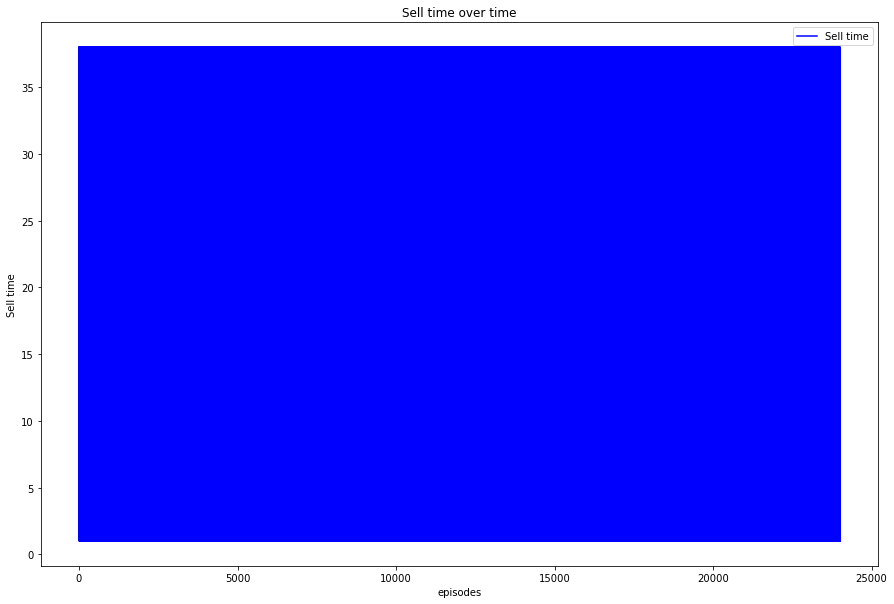

In [33]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [34]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:1'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))    

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.02148138054110948	12.97	0
episode 200: 	0.02675493007393255	14.94	0
episode 300: 	0.02508843269816029	12.79	0
episode 400: 	0.023494222074987258	14.25	0
episode 500: 	0.024848410319065088	15.96	0
episode 600: 	0.023904604283351713	17.64	0
episode 700: 	0.027361221507514792	17.54	0
episode 800: 	0.020033607304179468	13.14	0
episode 900: 	0.02610860175702012	16.68	0
episode 1000: 	0.025849011793978603	15.87	0
episode 1100: 	0.023572102173746688	14.76	0
episode 1200: 	0.02270940771614816	12.78	0
episode 1300: 	0.021487395234570092	13.31	0
episode 1400: 	0.01614974167459172	12.35	0
episode 1500: 	0.02764133942622956	16.1	0
episode 1600: 	0.028044230922365895	16.19	0
episode 1700: 	0.02735591605167298	14.45	0
episode 1800: 	0.02311366907728366	15.33	0
episode 1900: 	0.020411331152151366	13.73	0
episode 2000: 	0.0228150048981916	13.15	0
episode 2100: 	0.02706406117509016	15.1	0
episode 2200: 	0.020209092621880732	14.87	0
episode 2300: 	0.025909396885439202	14.86	0
episode 240

In [35]:
# 4000 episodes
# Select random state over history [Benchmark]
#Average reward per episode: 0.0015505754102431175%
#Time to execute: 0.07682177225748697min

#23000 episodes
# Average reward per episode: 0.0012894304336377236%
#Time to execute: 0.40911168257395425min

#23000 episodes
#Average reward per episode: 0.002274329489706149%
#Time to execute: 0.6566788395245869min

#23000 episodes
#Average reward per episode: 0.001215791565711024%
#Time to execute: 0.36365593671798707min

# 23000 episodes
#Total average reward per episode: 0.00036678919435973405
#Time to execute: 0.4333968202273051min

# 23000 episodes
#Total average reward per episode: 0.0010562361629312214
#Time to execute: 0.6513438741366069min

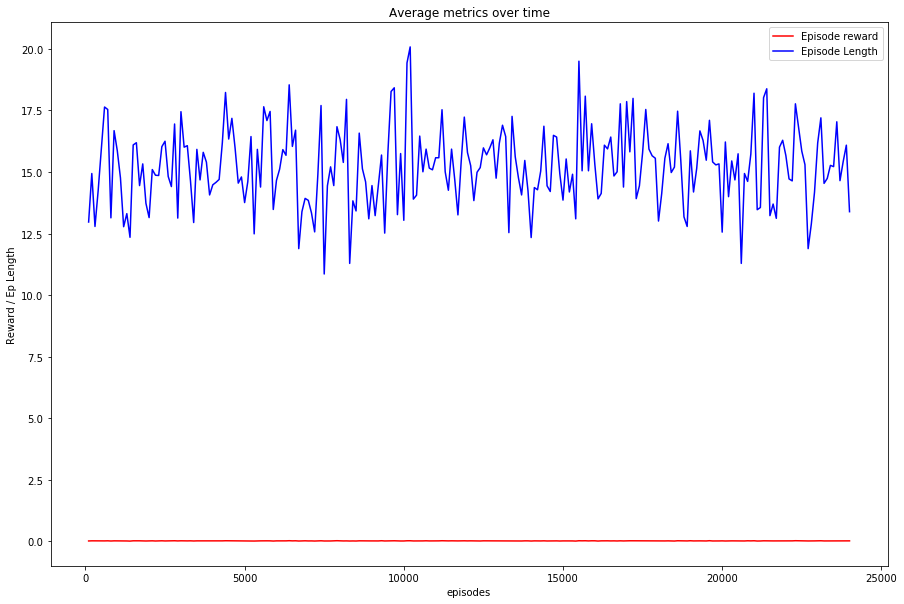

In [36]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

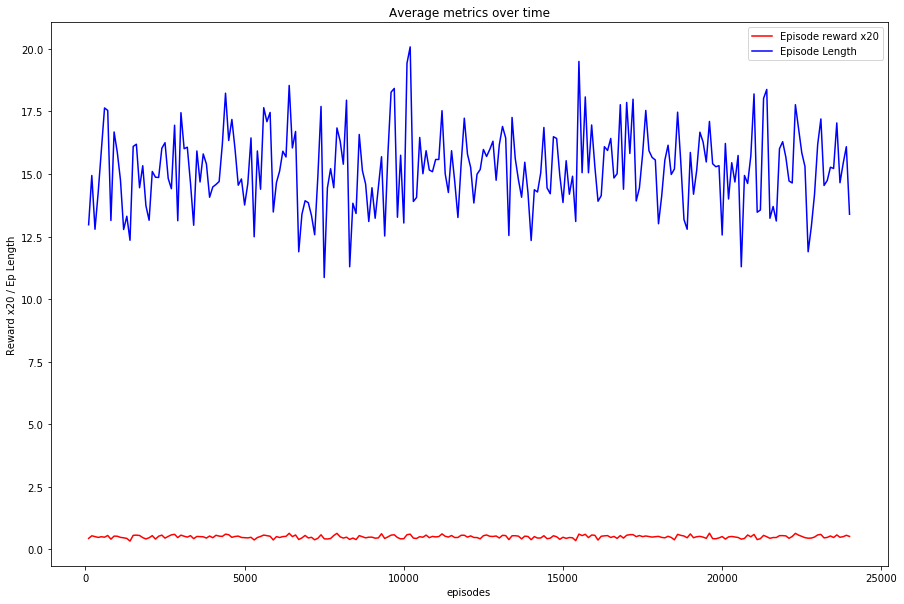

In [37]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

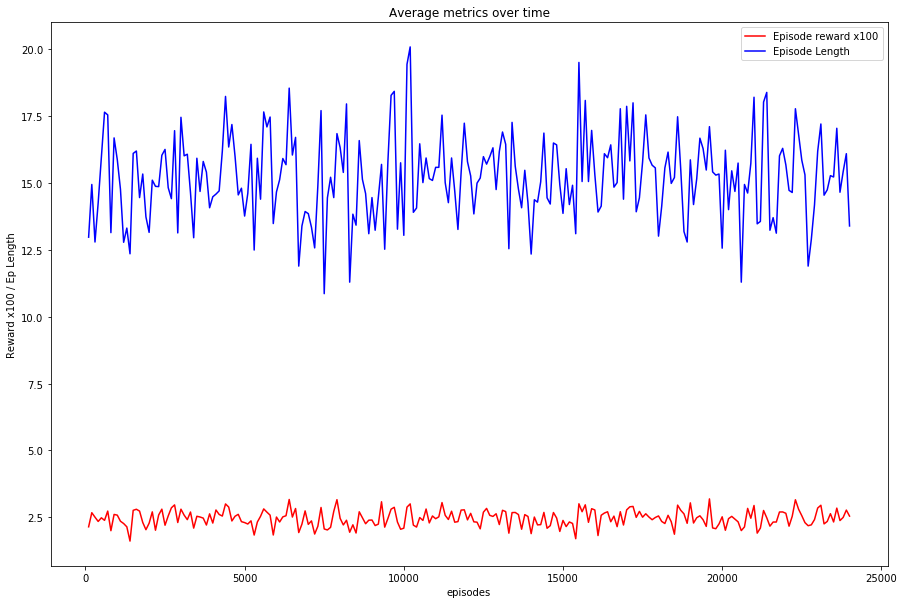

In [38]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

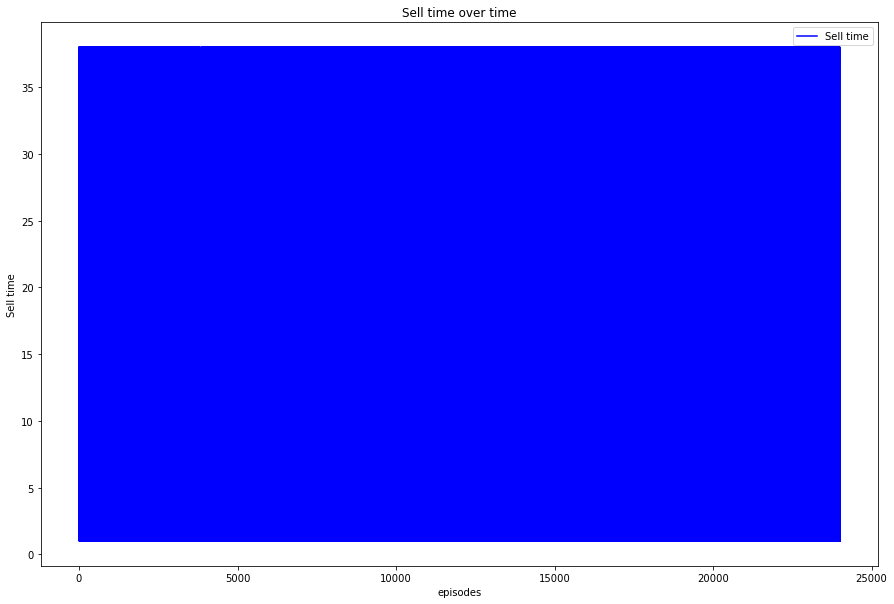

In [39]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [40]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []  

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:1'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.026221007580406987	16.17	0
episode 200: 	0.02761500867984468	18.39	0
episode 300: 	0.03004228328108191	17.28	0
episode 400: 	0.029231731722639456	19.13	0
episode 500: 	0.02538201177538868	20.61	0
episode 600: 	0.029486302945907976	19.5	0
episode 700: 	0.0341037250792363	21.35	0
episode 800: 	0.023413715875285703	16.91	0
episode 900: 	0.02977045687538082	20.24	0
episode 1000: 	0.025605071647911686	19.13	0
episode 1100: 	0.024942763907450618	16.91	0
episode 1200: 	0.028211546301342715	18.39	0
episode 1300: 	0.023751203999850392	16.91	0
episode 1400: 	0.021494323838889252	15.06	0
episode 1500: 	0.028721248602870147	19.5	0
episode 1600: 	0.02820122293318343	18.76	0
episode 1700: 	0.029229799863788535	18.76	0
episode 1800: 	0.028237029000265704	19.13	0
episode 1900: 	0.023121546293210112	17.65	0
episode 2000: 	0.026901016491695316	16.91	0
episode 2100: 	0.027901108556103137	18.39	0
episode 2200: 	0.02637037629457613	16.91	0
episode 2300: 	0.026596022956649125	17.28	0
episode

In [41]:
# 4600 episodes
#Average reward per episode: 0.001350523388538691%
#Time to execute: 0.08548296292622884min

#23000 episodes
#Average reward per episode: 0.002919471458257028%
#Time to execute: 0.32947063048680625min

# 23000 episodes
#Total average reward per episode: 0.003380776061516078
#Time to execute: 0.36532406012217206min

# 23000 episodes
#Total average reward per episode: 0.002987836452606828
#Time to execute: 0.5932944019635519min

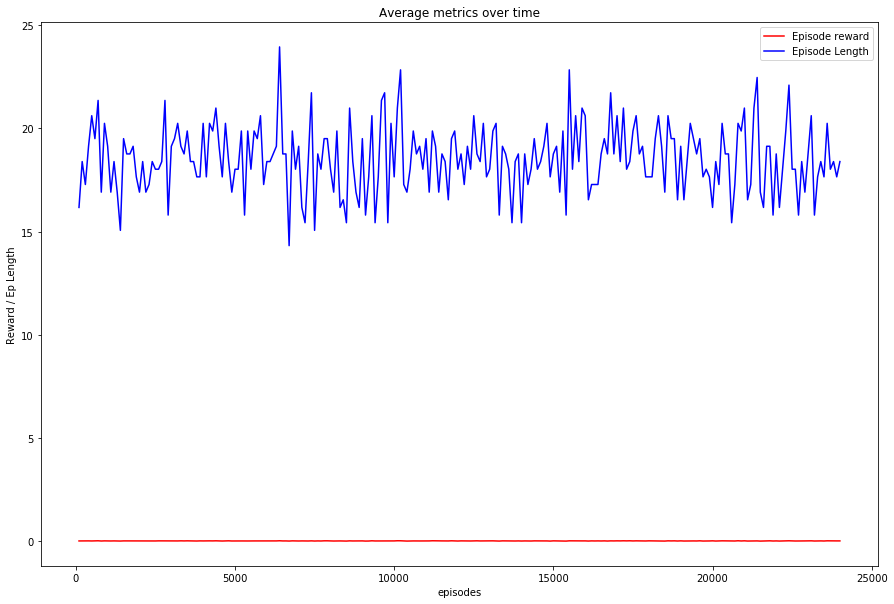

In [42]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

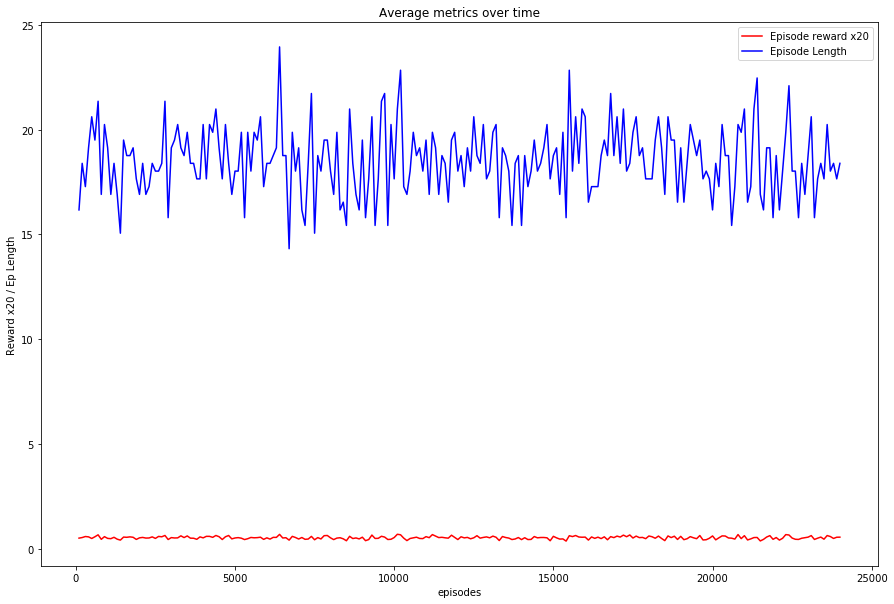

In [43]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

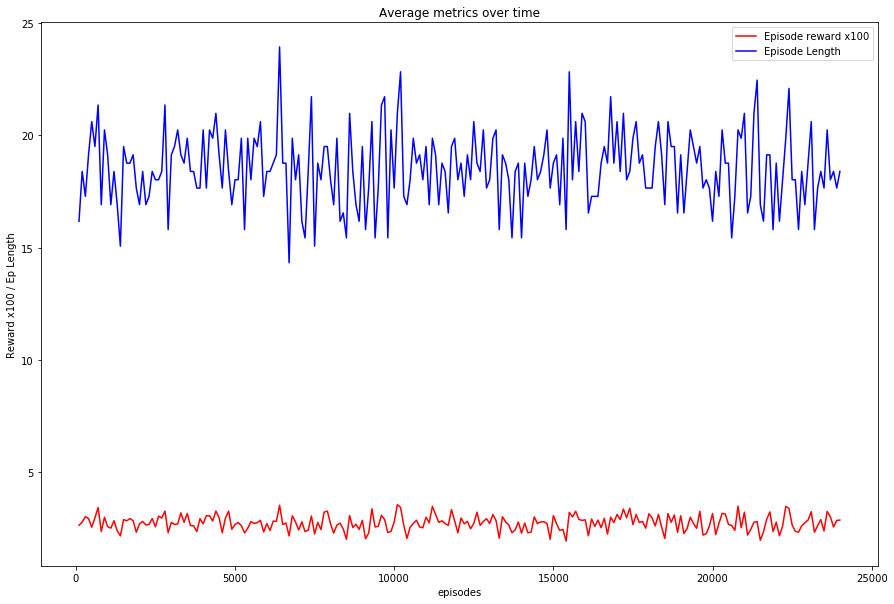

In [44]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

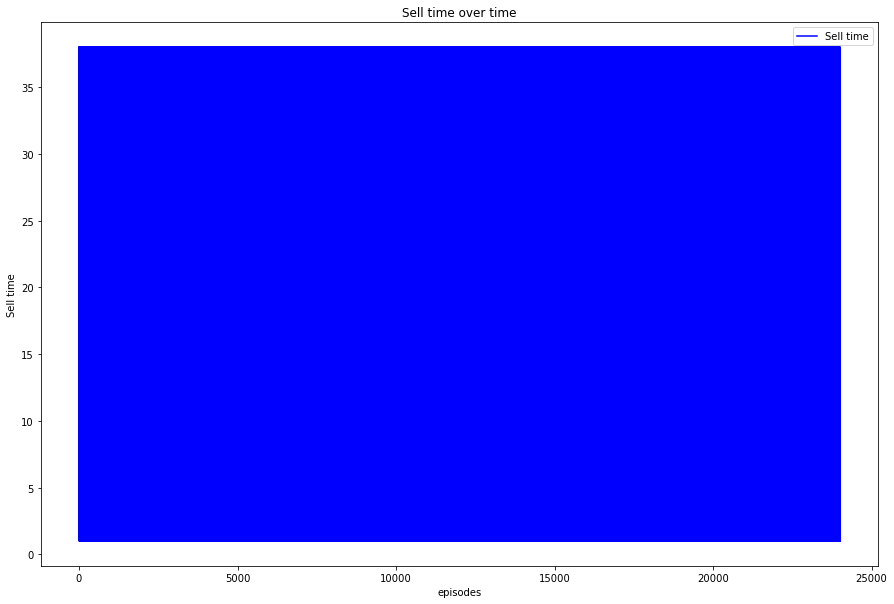

In [45]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part

In [46]:
"""stock_names = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',
               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',
               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', 'acta.us.txt',
               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',
              'pay.us.txt', 'peg.us.txt', 'tg.us.txt', 'tis.us.txt',
              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',
              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',
               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',
               'bbl.us.txt', 'ry.us.txt', 'asml.us.txt', 'nee.us.txt', 
              'txn.us.txt', 'gsk.us.txt', 'lly.us.txt', 'nvo.us.txt',
               'td.us.txt', 'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',
               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt',
              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']
# unvalid stocks: 'kst.us.txt', 'ddt.us.txt', 'lgl.us.txt', 'aac.us.txt','adom.us.txt','acrs.us.txt', 'delt.us.txt', 'lcahu.us.txt', 'tpge.us.txt', 'wear.us.txt'

stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r') """

"stock_names = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',\n               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',\n               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', 'acta.us.txt',\n               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',\n              'pay.us.txt', 'peg.us.txt', 'tg.us.txt', 'tis.us.txt',\n              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',\n              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',\n               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',\n               'bbl.us.txt', 'ry.us.txt', 'asml.us.txt', 'nee.us.txt', \n              'txn.us.txt', 'gsk.us.txt', 'lly.us.txt', 'nvo.us.txt',\n               'td.us.txt', 'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',\n               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt',\n              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']\n# unvalid stocks: 'kst.us.txt', 'ddt.us.txt', 'lgl.us.txt', 'aac.us.txt','adom.

min value of data: 108.87524389134241, max value of data: 188.56082216931188
train_size: 743
test_size: 185
min value of data: 128.61971170009193, max value of data: 274.35215354173266
train_size: 743
test_size: 185
min value of data: 62.03602991343512, max value of data: 95.64161820654094
train_size: 743
test_size: 185
min value of data: 148.92583383758014, max value of data: 296.08994342434
train_size: 743
test_size: 185
min value of data: 50.05087009447692, max value of data: 81.81118484899123
train_size: 743
test_size: 185
min value of data: 141.6679007915422, max value of data: 237.497617689898
train_size: 743
test_size: 185
min value of data: 143.1110091184379, max value of data: 258.42341925020963
train_size: 743
test_size: 185
min value of data: 81.51807513764079, max value of data: 143.1274713426479
train_size: 743
test_size: 185
min value of data: 51.4101233454379, max value of data: 89.80889577657041
train_size: 743
test_size: 185
min value of data: 121.58161811184277, max v

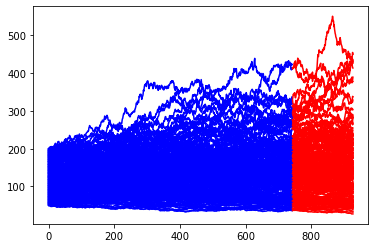

In [47]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    #train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 375
num_episodes_per_epoch: 24000
min value of stock: 176.43635326910925, max value of stock: 227.42584621096825


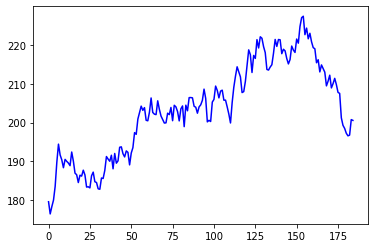

In [48]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [49]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/C51_noSoft_arch0-option_T50-history_t15-num_episodes203400-softUpdateFalse-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.03022670246430812	19.77
episode 200: 	0.023350460587122403	13.85
episode 300: 	0.03114243273390263	18.34
episode 400: 	0.020673653824841015	13.82
episode 500: 	0.02569365488851703	19.05
episode 600: 	0.031122470967298622	17.65
episode 700: 	0.02372391260192651	18.1
episode 800: 	0.036182913395959825	19.03
episode 900: 	0.025279512007949353	15.68
episode 1000: 	0.03008394168282391	15.19
episode 1100: 	0.028057097883508436	16.33
episode 1200: 	0.02513669142732316	17.81
episode 1300: 	0.029716380064421833	16.38
episode 1400: 	0.024962347870249632	15.25
episode 1500: 	0.03232913596344174	18.77
episode 1600: 	0.0370150485319879

In [50]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

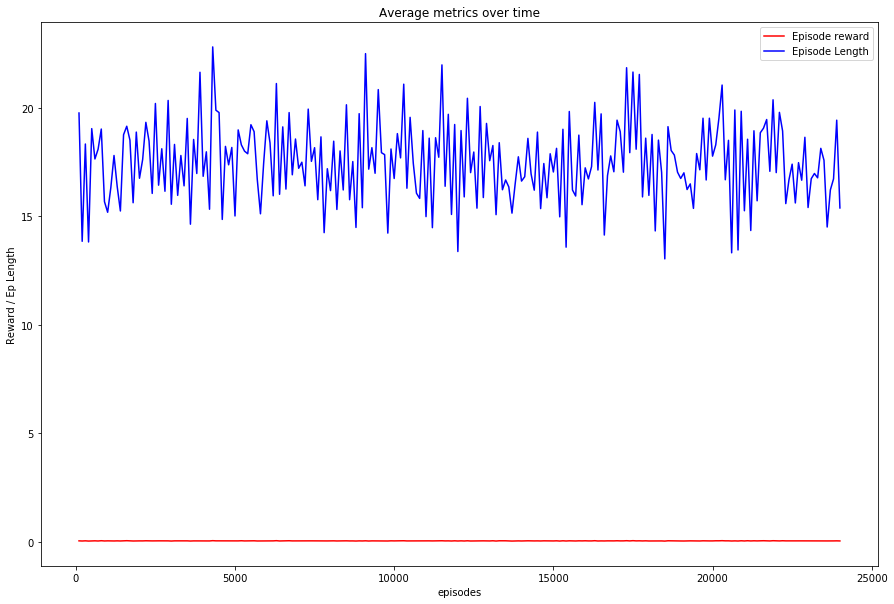

In [51]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

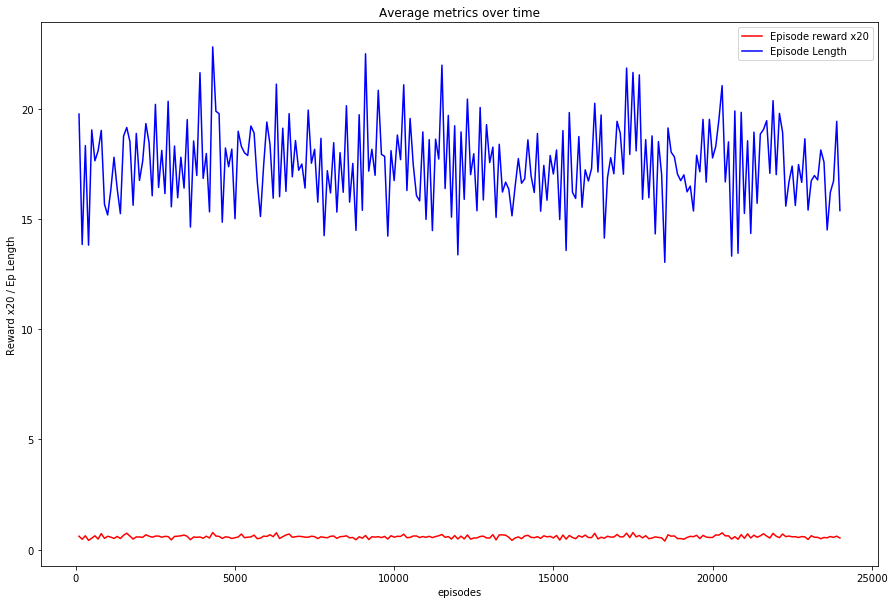

In [52]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

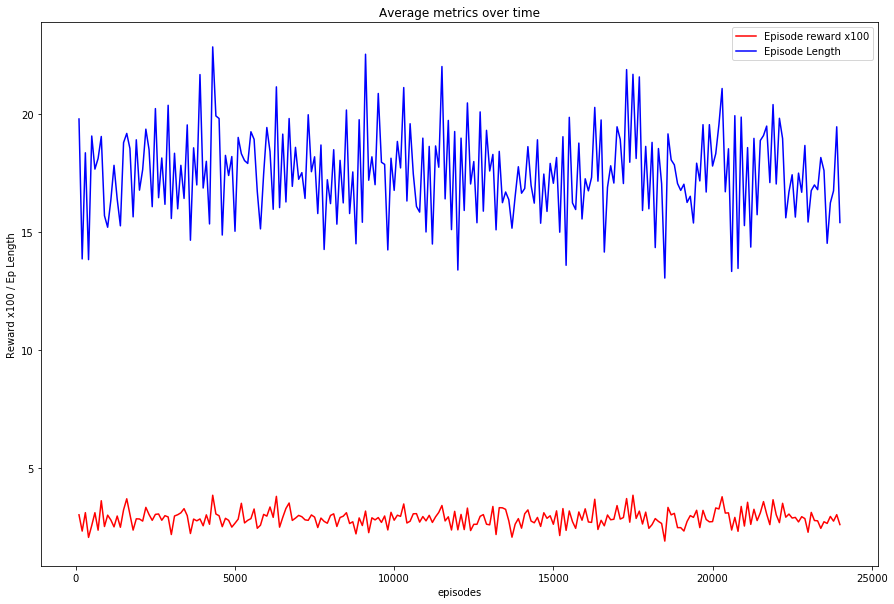

In [53]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

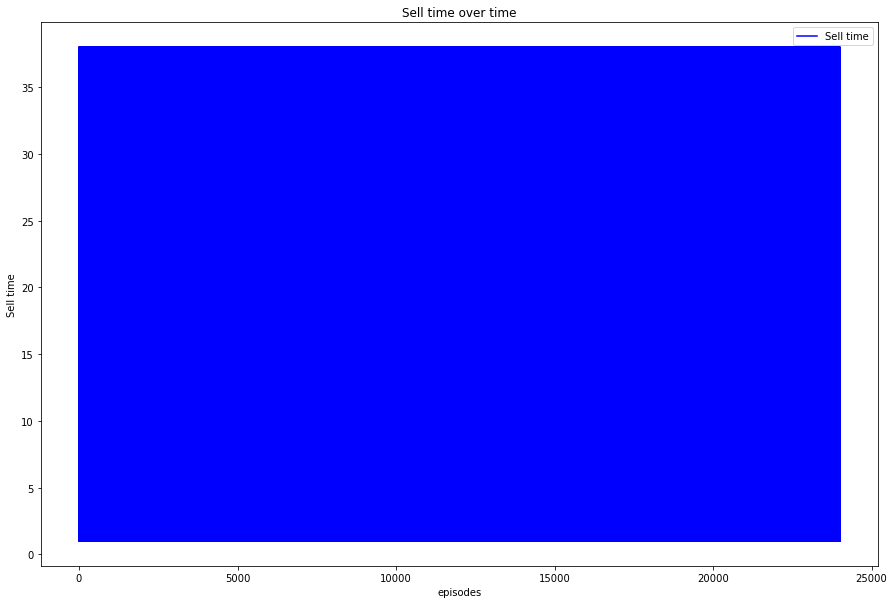

In [54]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 2118
num_episodes_per_epoch: 135600
min value of stock: 121.1553335570293, max value of stock: 180.06841858691385


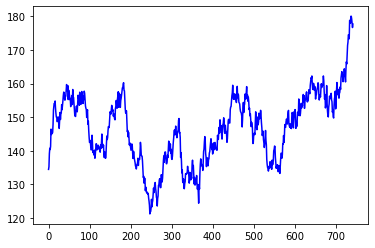

In [55]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [56]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/C51_noSoft_arch0-option_T50-history_t15-num_episodes203400-softUpdateFalse-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.023163844307517053	15.63
episode 200: 	0.03142109841150247	18.83
episode 300: 	0.02918555338424478	17.11
episode 400: 	0.03324172643550071	18.7
episode 500: 	0.02667880187614421	16.63
episode 600: 	0.024087351557628294	17.47
episode 700: 	0.029298568436289685	17.96
episode 800: 	0.030729731028683958	20.47
episode 900: 	0.031787278529761855	19.99
episode 1000: 	0.02684851846593303	20.07
episode 1100: 	0.02628554395685742	17.89
episode 1200: 	0.021121972147086606	16.8
episode 1300: 	0.030972295352544907	16.03
episode 1400: 	0.03165002397541122	19.54
episode 1500: 	0.029460202450632352	17.5
episode 1600: 	0.023568499617772187

In [57]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

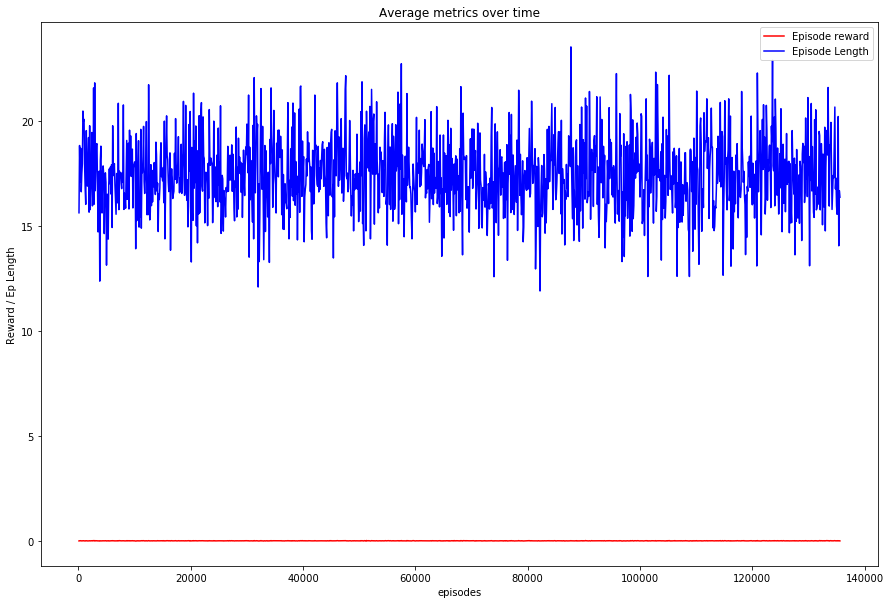

In [58]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

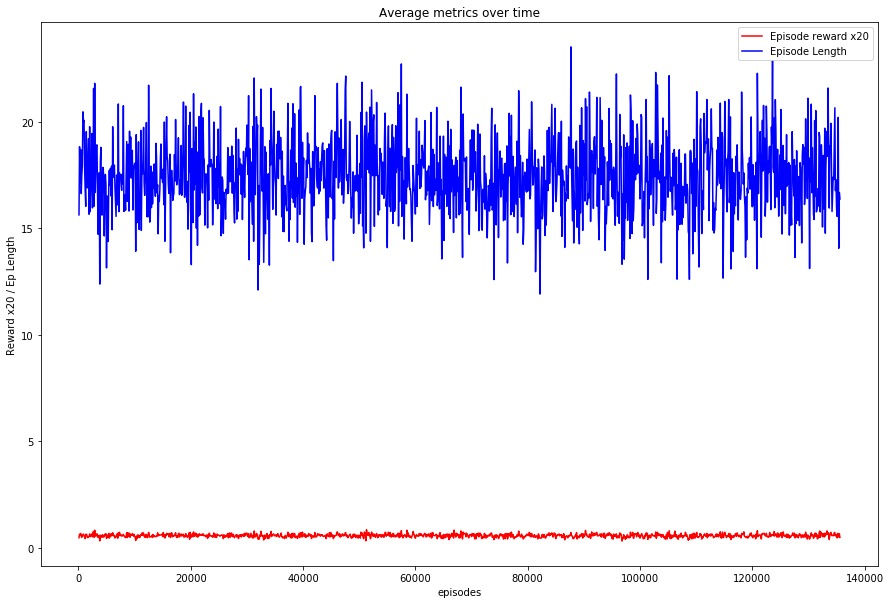

In [59]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

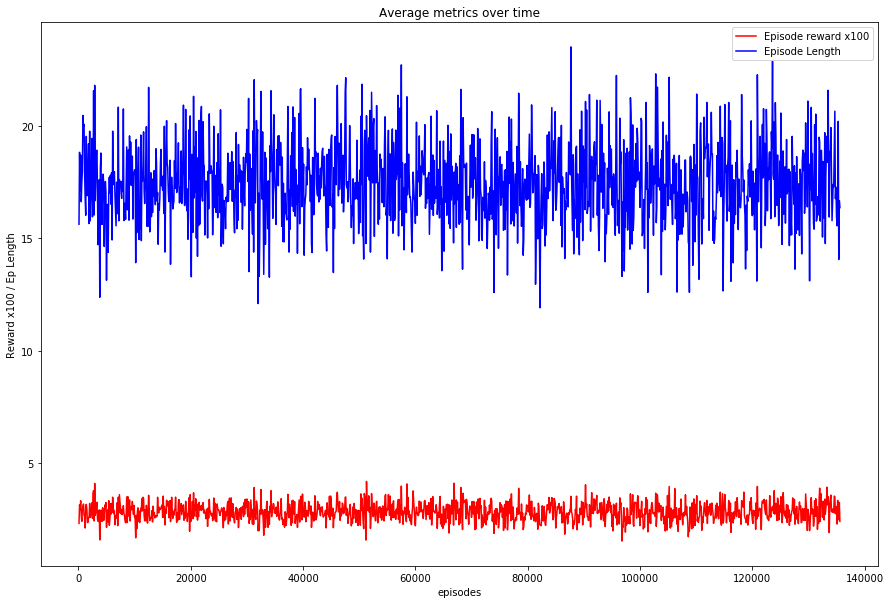

In [60]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

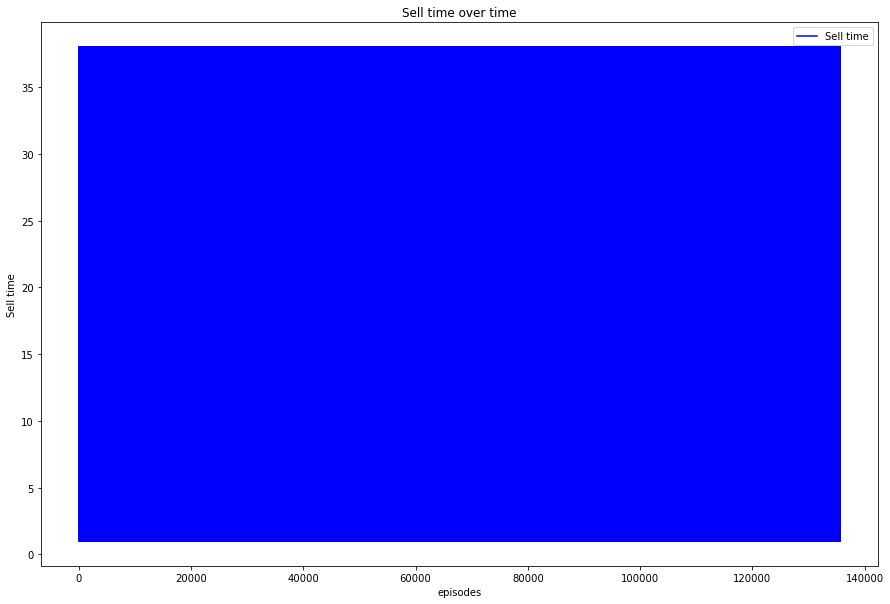

In [61]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [62]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

jList: 1174056
maxPossibleOptionP_returnList: 1174056
maxPossibleOptionR_P_returnList: 1174056
maxPossibleP_returnList: 1174056
maxPossibleR_P_returnList: 1174056
maxPossiblerList: 1174056
option_percentage_rList: 1174056
option_real_percentage_rList: 1174056
percentage_rList: 1174056
rList: 1174056
real_percentage_rList: 1174056
sTimeList: 1174056
AvgEpisodeList: 11528
AvgrList: 11528
AvgsTimeList: 11528
stock_data: 7992
real_train_data: 6040
train_data: 6040
Qnetwork: 2008
real_stocks_test_data: 1680
real_stocks_train_data: 1680
stocks_data: 1680
stocks_test_data: 1680
stocks_train_data: 1680
real_test_data: 1576
test_data: 1576
AmericanOptionPricing: 1064
GBM: 1064
MinMaxScaler: 1064
experience_buffer: 1064
episodeBuffer: 536
final_trained_model_name: 343
trained_model_name: 337
s1P: 232
sP: 232
path: 169
scriptDirectory: 158
build_data: 144
leaky_relu: 144
length: 144
normalize_data: 144
prepare_company_stock: 144
prepare_data: 144
processState: 144
set_seed: 144
updateTarget: 144
